<a href="https://colab.research.google.com/github/cyuancheng/NLP_Yelp_review/blob/master/NLP_1_twitter_NZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Natural Language Processing and Sentiment Analysis for Twitter##


Data exploration of new toothpaste product in Twitter

In [0]:
import spacy #use NLP functions
from spacy import displacy
from textblob import TextBlob
import tweepy #tweeter python package
import re
import en_core_web_sm #(python -m spacy download en_core_web_lg) # pre-train model sm: small
import pandas as pd
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

% matplotlib inline
import warnings
warnings.filterwarnings("ignore")

###1. Data process and cleaning###
Get data of "New Zealand" from Twitter API and wrangle the data using python. The Spacy and Texbolb packages are used for NLP.

Firstly, Let's write functions to get data from Twitter API.

In [0]:
class connection_twitter():
    def __init__(self,consumer_key, consumer_secret, access_token, access_token_secret, keyword):
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        self.api = tweepy.API(auth)
        self.key_word = [keyword]

        return None


#%%
# Structure the tweets

    def get_info(self,tweet):
        id = tweet.id
        text_ = tweet.full_text
        author = tweet.author
        date = tweet.created_at
        location = tweet.coordinates
        favorite_count = tweet.favorite_count

        user_favorite_count = tweet.user.favourites_count
        user_followers_count = tweet.user.followers_count
        user_location = tweet.user.location

        return id, text_, author, date, location, favorite_count, user_favorite_count, user_followers_count, user_location


    def get_texts(self):

        all_results = []
        for i in range(len(self.key_word)):
            tweets = tweepy.Cursor(self.api.search, q=self.key_word, lang = "en",tweet_mode='extended').items(100)
            result = [tweet for tweet in tweets]
            all_results.append(result)

        for i in range(len(all_results)):
            if i == 0:
                tweet_data = pd.DataFrame([self.get_info(tweet) for tweet in all_results[i]])

            else:
                tweet_data = pd.concat([pd.DataFrame([self.get_info(tweet) for tweet in all_results[i]]), tweet_data])

        tweet_data.columns = ['id', 'text_', 'author', 'date', 'location', 'favorite_count', 'user_favorite_count', 'user_followers_count', 'user_location']

        return tweet_data


Now, use keyword of "New Zealand" to pull data from Twitter API.

In [98]:
consumer_key = 'oxzQOYB3Yh1cTezTa0X9yYWaB'
consumer_secret = 'tL7HzTqiORDEvnzSq5ghsOwl9wl2ntlPT5Q8opdGMErltW1dr5'
access_token = '3579562937-XxUFCW12vuqHwjifqx0YTOAi8xzRKvIWPZsx5DV'
access_token_secret = '9b0WGTWIrSQZY7QAWtpXuZEkEKrKjKpKPcm70BFb9XrkD'

keyword = 'New Zealand'

twitter = connection_twitter(consumer_key,consumer_secret,access_token,access_token_secret,keyword)

data = twitter.get_texts()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
id                      100 non-null int64
text_                   100 non-null object
author                  100 non-null object
date                    100 non-null datetime64[ns]
location                0 non-null object
favorite_count          100 non-null int64
user_favorite_count     100 non-null int64
user_followers_count    100 non-null int64
user_location           100 non-null object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 7.1+ KB


Briefly take a look at the data

In [99]:
data.head()

,id,text_,author,date,location,favorite_count,user_favorite_count,user_followers_count,user_location
0,1106621272023359490,RT @WaqarHBhatti2: World media calls him shoot...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,227,459,الرياض
1,1106621272019087360,RT @LisaSmith4680: Are you dumb or are you jus...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,76452,2592,United States
2,1106621272018939904,RT @OCASI_Policy: Our thoughts are with the fa...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,3990,3650,"Toronto, Ontario"
3,1106621272002306048,Praying today for neighbors at the Islamic Cen...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,3116,2171,"Wheaton and Chicago, mostly"
4,1106621271821869056,RT @getongab: 4chan has reportedly been blocke...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,30663,1031,


Use TexBolb for the sentiment analysis in the "text_" column, and add "Polarity" and "Subjectivity" into the dataset

In [0]:
data['Polarity'] = [TextBlob(x).sentiment[0] for x in data['text_'] ]
data['Subjectivity'] = [TextBlob(x).sentiment[1] for x in data['text_'] ]

Next, we clean the data 
- replace empty data by nan
- groupby 'user_location'

In [101]:
data["user_location"].replace('', np.nan, inplace=True)
data1 = data.groupby('user_location').sum().sort_values(["Polarity"],ascending=True)
data1.head(5)

,id,favorite_count,user_favorite_count,user_followers_count,Polarity,Subjectivity
user_location,,,,,,
United States,2213242533892206592,0,204405,4016,-0.662273,1.502424
"Ohio, USA",1106621258681237504,0,71621,3959,-0.496212,0.818182
"Bruxelles, Belgique",1106621270022594560,0,31195,827,-0.381818,0.727273
"Meaty Flesh Prison, Earth",1106621271066828800,0,3075,149,-0.287879,0.484848
México,1106621265169842176,0,3806,41,-0.221212,0.784848


###2. Plotting###
Make a plot to compare polarity betweeen different location around the world

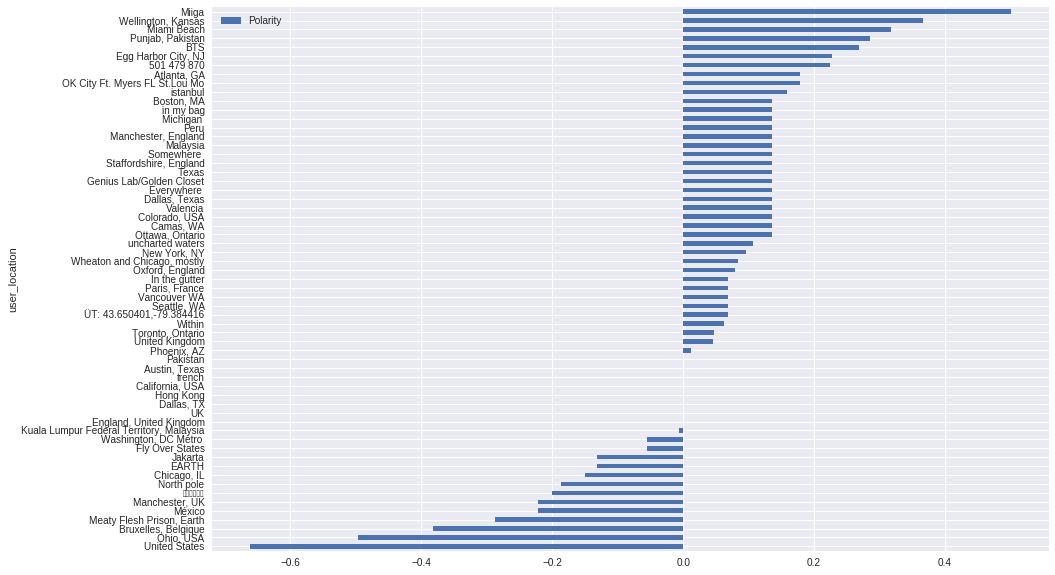

In [108]:
data1[['Polarity']].plot(kind='barh', figsize=(15, 10), legend=True)

In [104]:
print("statistics")
print("Positive: {0}" .format(len(data1[data1['Polarity']>0])))
print("Neutral: {0}" .format(len(data1[data1['Polarity']==0])))
print("Negative: {0}" .format(len(data1[data1['Polarity']<0])))

statistics
Positive: 39
Neutral: 8
Negative: 14


In [107]:
print(data['text_'][1])
print(data['Polarity'][1])
print(data['Subjectivity'][1])

#print(data['user_location'][5])
#data.iloc[64,:]

RT @LisaSmith4680: Are you dumb or are you just an evil lying, hating idiot politicizing a horrible tragedy?
New Zealand is NOT our 51st st…
-0.6077272727272727
0.7509090909090909


###3. Data process for wordcloud###
Try wordcloud
pre-process text column
postive / negative 

In [129]:
# print stop words from spacy
stopwords = spacy.lang.en.stop_words.STOP_WORDS
print(stopwords)

{'amount', 'an', 'give', 'really', 'sometime', 'as', 'its', 'hereupon', 'somehow', 'themselves', 'except', 'thereby', 'above', 'herself', 'regarding', 'seeming', 'were', 'against', 'fifteen', 'please', 'doing', 'up', 'has', 'your', 'me', 'anyone', 'do', 'go', 'alone', 'became', 'on', 'i', 'part', 'though', 'very', 'while', 'all', 'thru', 'you', 'whereafter', 'most', 'whom', 'between', 'could', 'just', 'whatever', 'yourselves', 'fifty', 'five', 'never', 'her', 'even', 'been', 'here', 'wherein', 'so', 'nobody', 'none', 'are', 'forty', 'quite', 'top', 'hers', 'this', 'seems', 'still', 'how', 'thereupon', 'due', 'whether', 'put', 'already', 'back', 'keep', 'from', 'with', 'some', 'throughout', 'call', 'move', 'because', 'seemed', 'only', 'can', 'the', 'onto', 'under', 'almost', 'would', 'someone', 'both', 'since', 'twelve', 'such', 'four', 'however', 'whereupon', 'last', 'why', 'latter', 'what', 'using', 'which', 'does', 'beyond', 're', 'before', 'and', 'neither', 'us', 'sixty', 'have', 'u

In [0]:
# check stop words
w = 'https'
nlp.vocab[w].is_stop = True
nlp.vocab['christchurch'].is_stop = True
nlp.vocab['new zealand'].is_stop = True

In [127]:
nlp('christchurch')[0].is_stop

True

In [112]:
#len(data['text_'])
data.head()

,id,text_,author,date,location,favorite_count,user_favorite_count,user_followers_count,user_location,Polarity,Subjectivity
0,1106621272023359490,RT @WaqarHBhatti2: World media calls him shoot...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,227,459,الرياض,-0.200000,0.000000
1,1106621272019087360,RT @LisaSmith4680: Are you dumb or are you jus...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,76452,2592,United States,-0.607727,0.750909
2,1106621272018939904,RT @OCASI_Policy: Our thoughts are with the fa...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,3990,3650,"Toronto, Ontario",-0.331818,0.727273
3,1106621272002306048,Praying today for neighbors at the Islamic Cen...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,3116,2171,"Wheaton and Chicago, mostly",0.084091,0.513636
4,1106621271821869056,RT @getongab: 4chan has reportedly been blocke...,User(_api=<tweepy.api.API object at 0x7f19758d...,2019-03-15 18:20:45,None,0,30663,1031,NaN,0.136364,0.454545


clean text in the "text_" column

In [0]:
data['text_clean'] = data['text_']

In [114]:
data['text_'][1].split(' ')

['RT',
 '@LisaSmith4680:',
 'Are',
 'you',
 'dumb',
 'or',
 'are',
 'you',
 'just',
 'an',
 'evil',
 'lying,',
 'hating',
 'idiot',
 'politicizing',
 'a',
 'horrible',
 'tragedy?\nNew',
 'Zealand',
 'is',
 'NOT',
 'our',
 '51st',
 'st…']

Remove punctuations, double space; put text in lower case

In [0]:
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub('  ', ' ', x))

In [0]:
# remove URLs, other words, and twitter handles

for i in range(len(data['text_'])):

    data['text_clean'][i] = " ".join([word for word in data['text_clean'][i].split(' ')
                                    if 'http' not in word \
                                      and '@' not in word \
                                      and '#' not in word\
                                      and '\n' not in word\
                                      and 'rt' not in word])


In [117]:
data['text_clean']

0     waqarhbhatti2 world media calls him shooter no...
1     lisasmith4680 are you dumb or are you just an ...
2     ocasi_policy our thoughts are with the familie...
3     praying today for neighbors at the islamic cen...
4        getongab 4chan has been blocked in new zealand
5     iyliasyazwanie new zealand terrorists korea hu...
6     amazing humanitarian care the jewish synagogue...
7     jgreenblattadl the alleged perpetrator of the ...
8     sabbiyahpervez at the multi faith prayer in br...
9     antihateca the yellow vests canada response to...
10    arbaazskhan newzealandshooting shocked speechl...
11    fazerug my for the people affected by this new...
12    prisonplanet the terrorist gunman who killed 4...
13    barackobama michelle and i send our condolence...
14    annie_khalid i am kill me in kill me in kill m...
15    muslimiq every single american murdered by ext...
16    hoarsewisperer unlike the united states new ze...
17    theresa_may on behalf of the uk my deepest

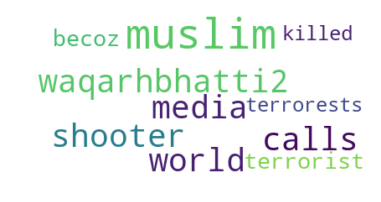

In [123]:
mpl.rcParams['figure.figsize']=(6.0,4.0)    #(6.0,4.0)
mpl.rcParams['font.size']=8               #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

#wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(data[][0])


stopwords1 = set(stopwords)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords1,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(data['text_clean'][0])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#print(wordcloud)
#fig = plt.figure(1)
#fig.savefig("word1.png", dpi=900)

In [119]:
print(data['text_clean'][0])

waqarhbhatti2 world media calls him shooter not terrorist becoz he was not a muslim terrorests killed 32 muslims i…


Print postive word by wordcloud

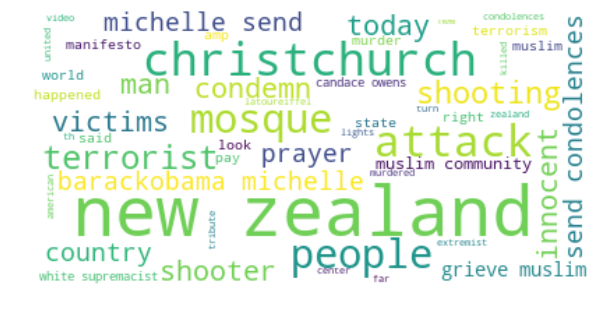

In [126]:
text_pro = ''
for text in data[data['Polarity']>0]['text_clean']:
  
  text_pro = text_pro + ' ' + text

#text_pro
stopwords1 = set(stopwords)

wordcloud = WordCloud(max_font_size=50, max_words=50, stopwords=stopwords1, background_color="white").generate(text_pro)

plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
  


print negative words by wordcloud

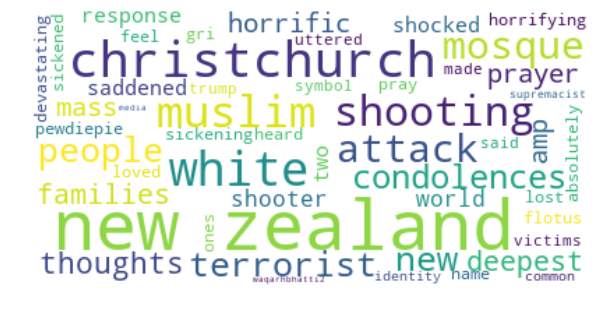

In [121]:
text_negative = ''
for text in data[data['Polarity']<0]['text_clean']:
  
  #if text not in spacy.lang.en.stop_words.STOP_WORDS:
  text_negative = text_negative + ' ' + text


text_negative

wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text_negative)

plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
  
 

In [0]:
text_negative

' isn\'t crunching ice bad for your teeth makes you wonder about their brand/choices sf tv commercial \'ice cruncher\' featuring luke wilson - ispottv white with green tea mint are you a little extra so am i so is my i recently tried out the whitening ad domoreforyourwholemouth ccbraves it’s happened to me a couple of times my 40 ounce both fights cavities and clearly will take down a plain always a regional too the other day i was in a bad mood so my mom offered to buy me some yeah mom some is gonna fix all my problems new post cvs mouthwash 500ml 99c/u *reg 549c/u* [termina [03/16/19] commercials representing "i\'m an asshole" and people just have to deal with my bad habits doesn\'t really spread a positive message don\'t find humor in making people vasan_bala vicky_donorr many asking for to make the opposite side of in all the tweets they haven\'t watch the advt intolerance and annoying the politicians made the people for their benefit i am sorry for those who are educated but still